In [ ]:
import pandas as pd
import numpy as np
import re

def clean_products(df):
    # Drop unnecessary columns
    df = df.drop(columns=['special_text', 'promo_text', 'link'], errors='ignore')
    
    # Remove duplicates
    df.drop_duplicates(subset=['product_code'], inplace=True)

    # Convert prices to numeric first
    for col in ['best_price', 'item_price','best_unit_price','price_was']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Now filter for positive prices (after conversion to numeric)
    df = df[df['item_price'].notna() & (df['item_price'] > 0)]
    df = df[df['best_unit_price'].notna() & (df['best_unit_price'] > 0)]
    df = df[df['price_was'].notna() & (df['price_was'] > 0)]

 
    # Extract price/unit
    def extract_price_unit(text):
        if pd.isna(text): return None, None
        text = str(text)
        price = re.search(r'\$([\d\.]+)', text)
        unit = re.search(r'per\s*(.*)', text, re.IGNORECASE)
        return (
            float(price.group(1)) if price else None,
            unit.group(1).strip().lower() if unit else None
        )

    # Drop rows with null unit_price before extraction
    df.dropna(subset=['unit_price'], inplace=True)

    # Apply extraction
    df[['unit_price_value', 'unit_of_measure']] = df['unit_price'].apply(
        lambda x: pd.Series(extract_price_unit(x))
    )

    # Standardize price per 100g/ml
    def base_price(row):
        u, p = str(row['unit_of_measure']), row['unit_price_value']
        if pd.isna(p) or pd.isna(u): return None
        u = u.lower()
        if "kg" in u: return p / 10
        if "g" in u: return p
        if "l" in u or "litre" in u: return p / 10
        if "ml" in u: return p
        if "ea" in u or "each" in u: return p
        return p

    df['base_unit_price'] = df.apply(base_price, axis=1)
    
    # Calculate discount (handle cases where best_price might be higher)
    df['discount_percentage'] = np.where(
        df['item_price'] > df['best_price'],
        (df['item_price'] - df['best_price']) / df['item_price'],
        0
    )

    return df.drop(columns=['unit_price'])

In [13]:
import pandas as pd
import glob
import os

def merge_product_files(data_folder='data'):
    """
    Merges all CSV files in the specified folder into a single DataFrame
    
    Args:
        data_folder (str): Path to folder containing CSV files
        
    Returns:
        pd.DataFrame: Combined product data with source file tracking
    """
    # Find all CSV files in the folder
    all_files = glob.glob(os.path.join(data_folder, "*.csv"))
    
    # Read and concatenate files
    dfs = []
    for file in all_files:
        df = pd.read_csv(file)
        df['source_file'] = os.path.basename(file)  # Track origin
        dfs.append(df)
    
    # Combine with duplicate handling
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Remove exact duplicates (same data from multiple files)
    combined_df.drop_duplicates(
        subset=['product_code'],  # Assuming this is your unique ID
        keep='first',
        inplace=True
    )
    
    return combined_df

In [15]:
folder_path = 'data'
products_df = merge_product_files(folder_path)   

In [10]:
products_df.head()

,_id,product_code,category,item_name,best_price,best_unit_price,item_price,unit_price,price_was,special_text,promo_text,link,source_file
0,67ed14d6a8bdc17e3ddceed5,8371390,Easter,Coles Hot Cross Buns Traditional Fruit | 6 Pack,$3.0,$0.73 per 1ea,$4.40,$0.73 per 1ea,NaN,SPECIAL,2 for $6,https://www.coles.com.au/product/coles-hot-cro...,ScrappedData.2025_04_02_Coles.csv
1,67ed14d6a8bdc17e3ddceed6,7473849,Easter,Coles Hot Cross Buns Choc Chip | 6 Pack,$3.0,$0.73 per 1ea,$4.40,$0.73 per 1ea,NaN,SPECIAL,2 for $6,https://www.coles.com.au/product/coles-hot-cro...,ScrappedData.2025_04_02_Coles.csv
2,67ed14d6a8bdc17e3ddceed7,5726070,Easter,Coles Hot Cross Buns Traditional Fruit Mini | ...,$3.0,$0.49 per 1ea,$4.40,$0.49 per 1ea,NaN,SPECIAL,2 for $6,https://www.coles.com.au/product/coles-hot-cro...,ScrappedData.2025_04_02_Coles.csv
3,67ed14d6a8bdc17e3ddceed9,4885191,Easter,Cadbury Dairy Milk Easter Chocolate Eggs Bag |...,$6.70,$5.88 per 100g,$6.70,$5.88 per 100g,NaN,NaN,NaN,https://www.coles.com.au/product/cadbury-dairy...,ScrappedData.2025_04_02_Coles.csv
4,67ed14d6a8bdc17e3ddceedb,3378370,Easter,Coles Hot Cross Buns Apple & Cinnamon | 6 Pack,$3.0,$0.73 per 1ea,$4.40,$0.73 per 1ea,NaN,SPECIAL,2 for $6,https://www.coles.com.au/product/coles-hot-cro...,ScrappedData.2025_04_02_Coles.csv


In [17]:
products_df = clean_products(products_df)

In [18]:
products_df.isna().sum()

_id                       0
product_code              0
category                  0
item_name                 0
best_price                0
best_unit_price        5186
item_price                0
price_was              5186
source_file               0
unit_price_value          0
unit_of_measure           0
base_unit_price           0
discount_percentage       0
dtype: int64

In [55]:
import random
from datetime import timedelta
import pandas as pd
import numpy as np
import uuid


def simulate_transactions(products_df, num_users=100, start_date="2022-08-01", end_date="2025-08-01"):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Popularity tiers
    codes = products_df['product_code'].unique()
    np.random.shuffle(codes)
    high, med = codes[:int(0.2*len(codes))], codes[int(0.2*len(codes)):int(0.5*len(codes))]
    low = codes[int(0.5*len(codes)):]

    user_ids = [f"user_{i}" for i in range(1, num_users+1)]
    seg_loyal = set(random.sample(user_ids, int(0.3*num_users)))
    seg_freq = set(random.sample(list(set(user_ids) - seg_loyal), int(0.2*num_users)))

    rows = []
    for user in user_ids:
        # Decide number of shopping events per user
        if user in seg_loyal:
            transaction_count = random.randint(800, 1200)
        elif user in seg_freq:
            transaction_count = random.randint(500, 800)
        else:
            transaction_count = random.randint(100, 500)

        history = []
        for _ in range(transaction_count):
            date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
            num_items = random.randint(4, 7)  # basket size
            basket = set()  # to avoid duplicates

            while len(basket) < num_items:
                # if random.random() < 0.8 and history:
                #     product = random.choice(history)
                # else:
                #     tier = np.random.choice(['high', 'medium', 'low'], p=[0.5, 0.3, 0.2])
                #     product = random.choice(high if tier == 'high' else med if tier == 'medium' else low)

                if random.random() < 0.8 and history:
                    product = random.choice(history)
                else:
                    tier = np.random.choice(['high', 'medium', 'low'], p=[0.5, 0.3, 0.2])
                    product = random.choice(high if tier == 'high' else med if tier == 'medium' else low)


                if product not in basket:  # allow rare duplicates if habitual
                    basket.add(product)
                    history.append(product)

                    prod_info = products_df.loc[products_df['product_code'] == product].iloc[0]
                    price = (
                        prod_info['best_price'] * (1 - random.uniform(0, 0.1))
                        if user in seg_loyal
                        else prod_info['item_price'] * (1 + random.uniform(0, 0.05))
                    )
                     # Generate a unique ID
                    trans_id = uuid.uuid4().hex[:10]  # Shortened UUID
                    rows.append([trans_id, user, product, date, price])

    return pd.DataFrame(rows, columns=['transaction_id','user_id', 'product_code', 'transaction_date', 'transaction_price'])


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_purchase_distributions(df):
    """
    Plots two key distributions:
    1. Transactions per User
    2. Purchases per Product

    Parameters:
        df (pd.DataFrame): DataFrame containing transaction data with:
            - user_id: Unique user identifiers
            - product_code: Unique product identifiers
            - transaction_date: Date of transaction (datetime)
    """
    # Set style and colors
    sns.set_style("whitegrid")
    primary_color = "#D62728"  # Coles red
    secondary_color = "#2CA02C"  # Complementary green

    # Ensure datetime format
    df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Transactions per User ---
    user_counts = df['user_id'].value_counts()
    sns.histplot(user_counts, ax=ax1, bins=30, color=primary_color,
                 edgecolor="white", linewidth=0.5, kde=True)

    ax1.set_title("Transactions per User Distribution", pad=20, fontsize=14)
    ax1.set_xlabel("Number of Transactions", labelpad=10)
    ax1.set_ylabel("Number of Users", labelpad=10)

    # Add statistical annotations
    stats_text = (f"Total Users: {len(user_counts):,}\n"
                  f"Mean: {user_counts.mean():.1f}\n"
                  f"Median: {user_counts.median():.1f}\n"
                  f"Top User: {user_counts.max():,} transactions")

    ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes,
             ha='right', va='top', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # --- Purchases per Product ---
    product_counts = df['product_code'].value_counts()
    sns.histplot(product_counts, ax=ax2, bins=30, color=secondary_color,
                 edgecolor="white", linewidth=0.5, kde=True)

    ax2.set_title("Purchases per Product Distribution", pad=20, fontsize=14)
    ax2.set_xlabel("Number of Purchases", labelpad=10)
    ax2.set_ylabel("Number of Products", labelpad=10)

    # Add statistical annotations
    stats_text = (f"Total Products: {len(product_counts):,}\n"
                  f"Mean: {product_counts.mean():.1f}\n"
                  f"Median: {product_counts.median():.1f}\n"
                  f"Top Product: {product_counts.max():,} purchases")

    ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes,
             ha='right', va='top', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Final adjustments
    plt.tight_layout(pad=3)
    plt.show()

In [60]:
# Use the improved simulation function
trans_df = simulate_transactions(products_df, num_users=100)
# Merge with product data
trans_df = pd.merge(trans_df, products_df, on='product_code', how='left')

In [61]:
to_display = ['transaction_id', 'user_id', 'product_code', 'transaction_date',
       'transaction_price', 'item_name', 'item_price', 'unit_price_value', 'discount_percentage']

trans_df = trans_df [to_display]
trans_df.head()

,transaction_id,user_id,product_code,transaction_date,transaction_price,item_name,item_price,unit_price_value,discount_percentage
0,82164147c0,user_1,3615475,2023-01-28,28.342394,Excellence 6.30 Light Golden Brown,27.0,13.50,0.500000
1,d0542ce842,user_1,3498780,2023-01-28,5.149217,Classic Japanese Teriyaki Marinade,5.0,1.67,0.200000
2,523e25dc3d,user_1,9999325,2023-01-28,2.603196,Rice Crackers Cheese,2.5,2.06,0.260000
3,b4779b2dce,user_1,7671729,2023-01-28,6.194063,Peanut Pretzel,6.0,5.33,0.200000
4,3b641b49fe,user_1,5050822,2023-01-28,4.575063,Pesto Basilico,4.5,1.21,0.222222


In [62]:
# Group items by transaction_id to see multi-product baskets
transactions_grouped = trans_df.groupby('transaction_id').agg({
    'user_id': 'first',
    'transaction_date': 'first',
    'product_code': list,  # All products in transaction
    'item_name': list,
    'transaction_price': 'sum',  # Total basket value
    'discount_percentage': 'mean'  # Average discount
}).reset_index()

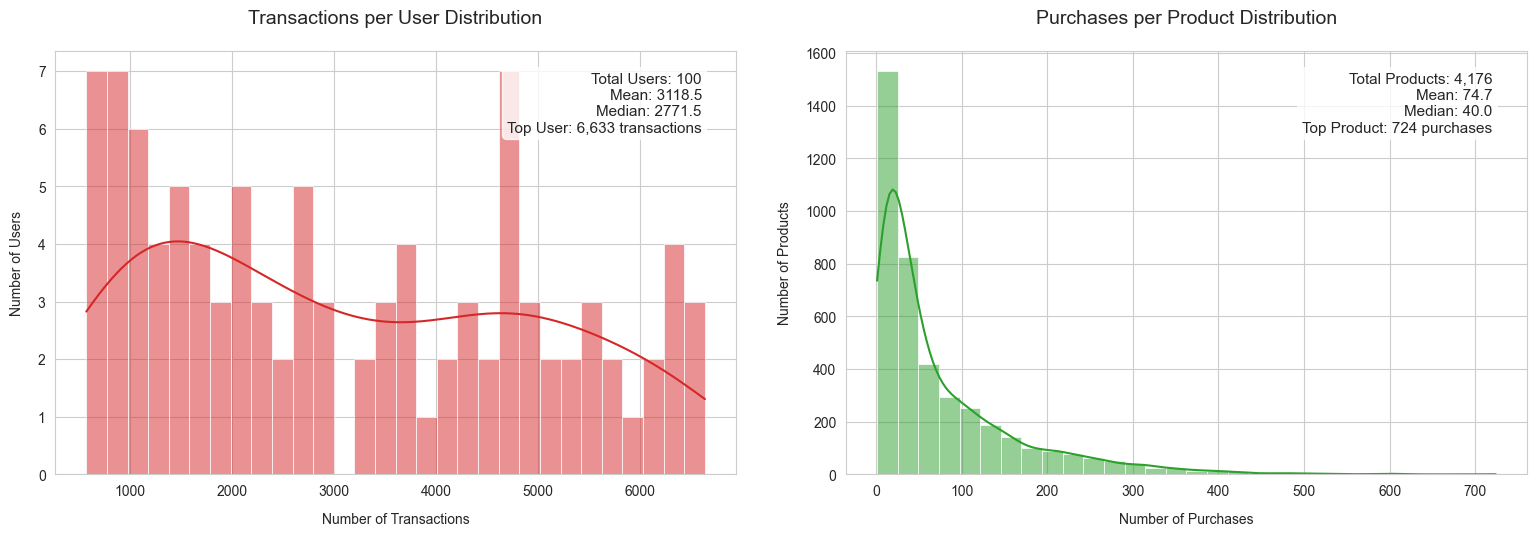

In [64]:
plot_purchase_distributions(trans_df)

In [65]:
def compute_features(trans_df):
    today = trans_df['transaction_date'].max()

    # Recency
    recency = trans_df.groupby(['user_id','product_code'])['transaction_date'].max().reset_index()
    recency['recency_days'] = (today - recency['transaction_date']).dt.days

    # Frequency (30-day)
    freq_30d = trans_df[trans_df['transaction_date'] >= (today - timedelta(days=30))] \
               .groupby(['user_id','product_code']).size().rename('freq_30d')

    # Budget Alignment (Fixed)
    avg_spend = trans_df.groupby('user_id')['transaction_price'].mean().rename('avg_spend')
    budget = trans_df.merge(avg_spend, on='user_id')
    budget['budget_alignment'] = (1 - (abs(budget['transaction_price']-budget['avg_spend'])/budget['avg_spend'])).clip(lower=0)
    budget = budget.groupby(['user_id','product_code'])['budget_alignment'].mean().reset_index()

    return recency.merge(freq_30d, on=['user_id','product_code'], how='left') \
                 .merge(budget, on=['user_id','product_code'], how='left') \
                 .fillna(0)

In [66]:
df = compute_features(trans_df)
df[df['freq_30d'] > 5].head(20)

,user_id,product_code,transaction_date,recency_days,freq_30d,budget_alignment
453,user_10,3568590,2025-07-27,5,10.0,0.324897
827,user_10,6376960,2025-07-29,3,8.0,0.319337
974,user_10,7755670,2025-07-28,4,6.0,0.470604
1197,user_10,9280325,2025-07-29,3,7.0,0.449431
1237,user_100,162658,2025-07-29,3,7.0,0.296746
1975,user_12,134608,2025-07-26,6,6.0,0.000000
2300,user_12,7030859,2025-07-26,6,6.0,0.316817
3054,user_14,3871329,2025-07-25,7,6.0,0.281318
3061,user_14,3893128,2025-07-30,2,9.0,0.000000
3591,user_14,8423369,2025-07-25,7,6.0,0.033821


In [67]:
df = compute_features(trans_df)
df[df['recency_days'] > 5].head(20)

,user_id,product_code,transaction_date,recency_days,freq_30d,budget_alignment
0,user_1,43182,2024-09-04,331,0.0,0.000000
1,user_1,128911,2025-06-22,40,0.0,0.176738
2,user_1,134608,2024-06-08,419,0.0,0.000000
3,user_1,309461,2023-06-12,781,0.0,0.830809
4,user_1,1022600,2024-02-29,519,0.0,0.341099
5,user_1,1311141,2024-05-21,437,0.0,0.448673
6,user_1,1423247,2025-06-29,33,0.0,0.363650
7,user_1,1481141,2024-10-20,285,0.0,0.384957
8,user_1,1733834,2025-05-18,75,0.0,0.962990
9,user_1,1847662,2023-12-25,585,0.0,0.252716


In [ ]:
trans_df.columns

Index(['transaction_id', 'user_id', 'product_code', 'transaction_date',
       'transaction_price', 'item_name', 'item_price', 'unit_price_value',
       'discount_percentage'],
      dtype='object')